Alpha
dict_keys(['analysis', 'baselineScore', 'bestModelAICc', 'breakpointData', 'improvements', 'input', 'potentialBreakpoints', 'singleTreeAICc', 'siteBreakPointSupport', 'timeElapsed', 'totalModelCount', 'trees'])
1 902
903 968
969 1028
1029 1205
1206 1448
1449 2040
2041 2416
Beta
dict_keys(['analysis', 'baselineScore', 'bestModelAICc', 'breakpointData', 'improvements', 'input', 'potentialBreakpoints', 'singleTreeAICc', 'siteBreakPointSupport', 'timeElapsed', 'totalModelCount', 'trees'])
1 203
204 626
627 807
808 1046
1047 1106
1107 1613
1614 1933
1934 1986
Gamma
dict_keys(['analysis', 'baselineScore', 'bestModelAICc', 'breakpointData', 'improvements', 'input', 'potentialBreakpoints', 'singleTreeAICc', 'siteBreakPointSupport', 'timeElapsed', 'totalModelCount', 'trees'])
1 178
179 677
678 822
823 1034
1035 1442
1443 1889
1890 1992
Alpha
dict_keys(['analysis', 'baselineScore', 'bestModelAICc', 'breakpointData', 'improvements', 'input', 'potentialBreakpoints', 'singleTreeAICc', 'siteBr

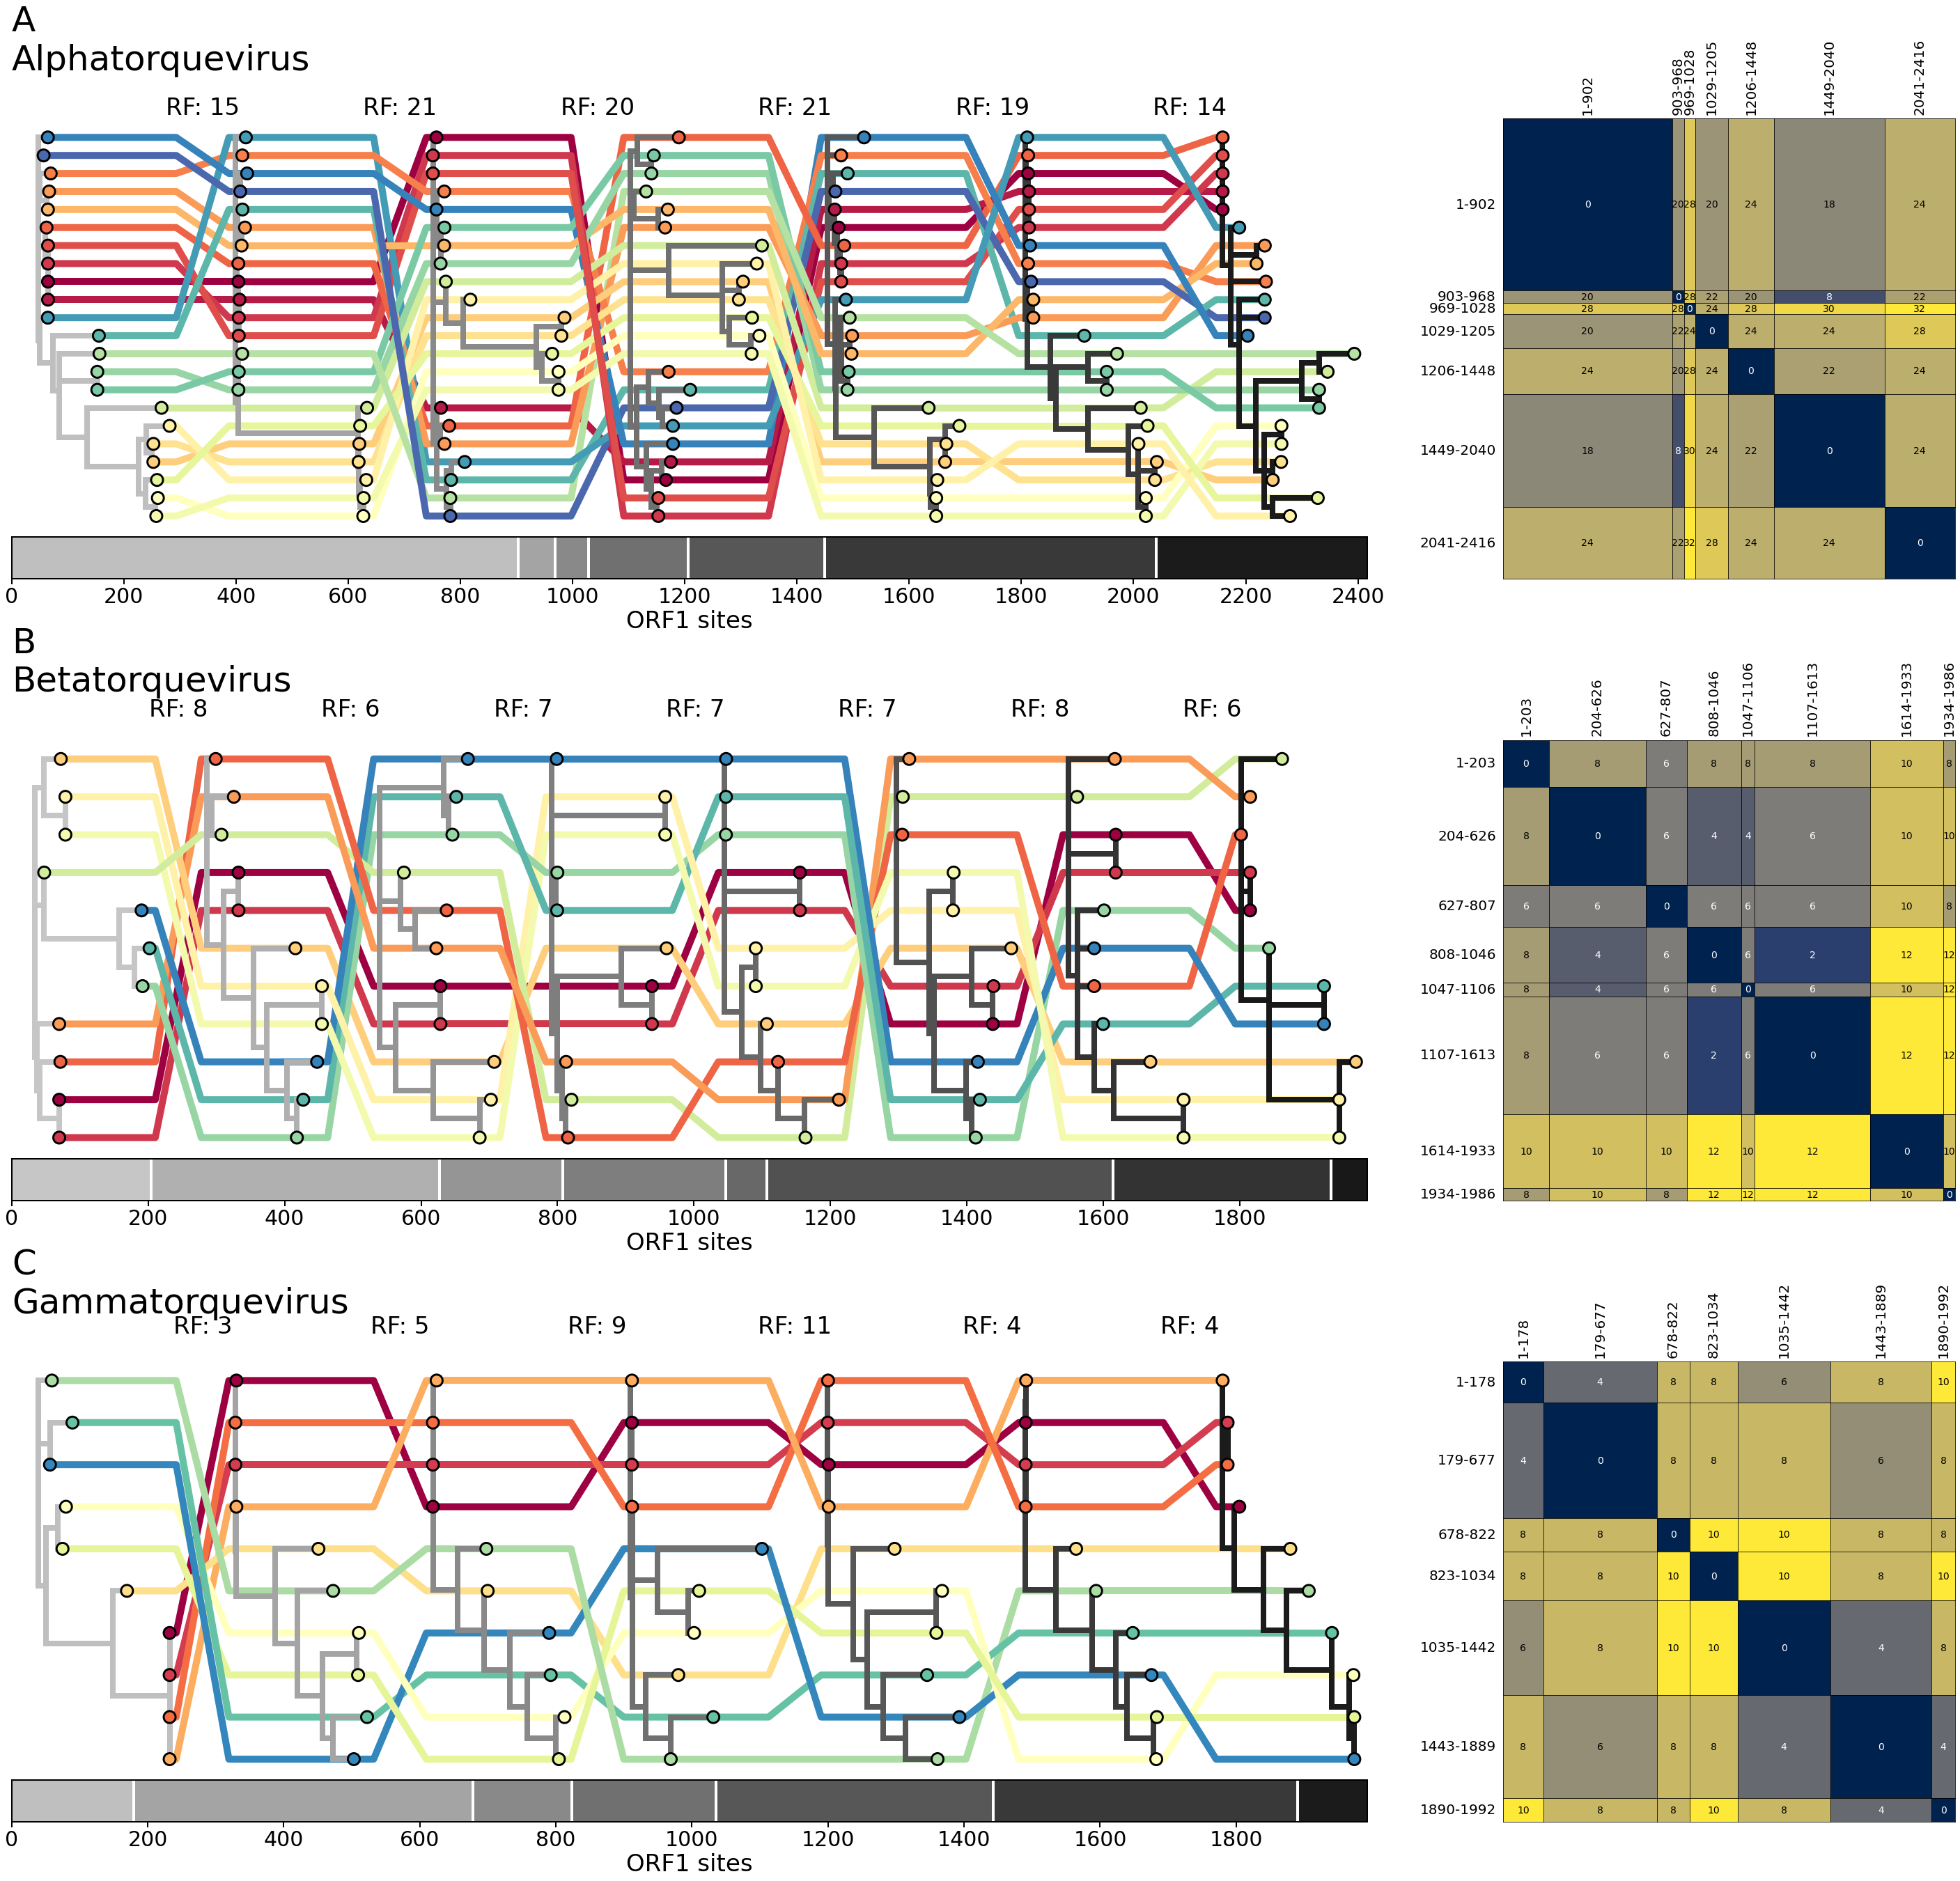

In [2]:
import pathlib

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

import baltic as bt
import ete3

import os,glob,json,pathlib

base_path=pathlib.Path(os.path.abspath('')).parent
data_path=pathlib.Path(base_path).joinpath("data", "figure_S4")

fig = plt.figure(figsize=(50,45),facecolor='w')
main_gs = GridSpec(3,2,height_ratios=[1,1,1],width_ratios=[3,1],hspace=0.35,wspace=0.15)

for (idx, (label, fname)) in enumerate(zip(['A','B','C'], sorted(glob.glob(str(data_path.joinpath("*GARD*.json")))))):
    outer_cell = main_gs[idx, 0]
    
    f=os.path.basename(fname).split('_')[0]
    print(f)
    gard=json.load(open(fname,'r'))    
    print(gard.keys())

    br=[]
    trees={}
    tip_positions={}
    for frag in gard['breakpointData']:
        m,M=gard['breakpointData'][frag]['bps'][0]

        br+=[m,M]
        tree_string='%s;'%(gard['breakpointData'][frag]['tree'])

        trees[frag]=bt.make_tree(tree_string)
        ll=trees[frag]
        
        ll.traverse_tree()
        ll.drawTree()
        
        ll=ll.collapseBranches(lambda k: k.length==0.0)
        
        ll.sortBranches()
        
        tip_positions[frag]={}

        for k in ll.getExternal():
            tip_positions[frag][k.name]=k.y
        
        trees[frag]=ll
    
    gs = GridSpecFromSubplotSpec(2, 1,outer_cell,hspace=0.01,wspace=0.01,height_ratios=[10,1])
    ax = plt.subplot(gs[0])

    ax.text(0.0,1.1,"%s\n%storquevirus"%(label,f),size=50,ha='left',va='bottom',transform=ax.transAxes)

    cumulative_x=0
    
    tip_colours={k.name: mpl.cm.Spectral(i/len(trees['0'].getExternal())) for i,k in enumerate(trees['0'].getExternal())}
    
    tree_colours={frag: mpl.cm.Greys((f+4)/(len(gard['breakpointData'])+4)) for f,frag in enumerate(gard['breakpointData'])}
    
    for t in trees:
        ll=trees[t]
        x_attr=lambda k: cumulative_x+k.height/ll.treeHeight
        
        ll.plotTree(ax,x_attr=x_attr,width=8,zorder=100,colour=tree_colours[t])
        ll.plotPoints(ax,x_attr=x_attr,size=200,colour=lambda k: tip_colours[k.name],zorder=101)

        ax.plot()

        #### Robinson-Foulds distances
        l1=trees[t] ## grab tree 1
        
        space=0.5
        if int(t)<len(trees)-1:
            nt=str(int(t)+1)
            
            l2=trees[nt] ## grab tree 2
            L1=ete3.Tree(l1.toString(traits=[])) ## convert to ete3
            L2=ete3.Tree(l2.toString(traits=[]))
            
            rf=L1.robinson_foulds(L2,unrooted_trees=True)[0] ## get RF distance
            ax.text(cumulative_x+1+space/2,l1.ySpan+0.5,'RF: %d'%(rf),size=34,ha='center',va='bottom')
            
            for k in ll.getExternal():
                matching_tip=trees[nt].getExternal(lambda w: w.name==k.name)[0]
                x1=x_attr(k)
                x2=cumulative_x+1+0.1*space
                x3=cumulative_x+1+0.9*space
                x4=cumulative_x+1+space+matching_tip.height/trees[nt].treeHeight
                ax.plot([x1,x2,x3,x4],[k.y,k.y,matching_tip.y,matching_tip.y],color=tip_colours[k.name],lw=10,zorder=0)
                
        cumulative_x+=1+space
        

    ax.set_xlim(-0.2,cumulative_x-space*0.8)
    [ax.spines[loc].set_visible(False) for loc in ax.spines]
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    ax2 = plt.subplot(gs[1])
    
    for frag in gard['breakpointData']:
        m,M=gard['breakpointData'][frag]['bps'][0]
        print(m,M)
        if m==1:
            p=M
        else:
            p=m

            ax2.axvline(p,0,1,color='w',lw=4)
    
        ax2.axvspan(m,M,facecolor=tree_colours[frag],edgecolor='none')
    
    ax2.set_xlim(0,M+1)
    ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.tick_params(labelsize=30,size=8,width=2)
    ax2.set_xlabel('ORF1 sites',size=34)
    [ax2.spines[loc].set_linewidth(2) for loc in ax2.spines]
    
for (idx,fname) in enumerate(sorted(glob.glob(str(data_path.joinpath("*GARD*.json"))))):
    outer_cell = main_gs[idx, 1]
    f=os.path.basename(fname).split('_')[0]
    print(f)
    gard=json.load(open(fname,'r'))
    print(gard.keys())
    
    trees=[]
    widths=[]
    labels=[]
    for frag in gard['breakpointData']:
        m,M=gard['breakpointData'][frag]['bps'][0]
        br+=[m,M]
        labels.append('%d-%d'%(m,M))
        widths.append(M-m)
        
        tree_string='%s;'%(gard['breakpointData'][frag]['tree'])
        
        ll=bt.make_tree(tree_string)
        ll.traverse_tree()
        trees.append(ll)
        
    gs = GridSpecFromSubplotSpec(len(widths), len(widths),outer_cell,hspace=0.00,wspace=0.00,height_ratios=widths,width_ratios=widths)  
    
    matrix={i: {j: np.nan for j in range(len(widths))} for i in range(len(widths))}
    
    for i,y in enumerate(widths):
        for j,x in enumerate(widths):
            L1=ete3.Tree(trees[i].toString(traits=[])) ## convert to ete3
            L2=ete3.Tree(trees[j].toString(traits=[]))
            
            rf=L1.robinson_foulds(L2,unrooted_trees=True)[0] ## get RF distance
            matrix[i][j]=rf
    
    cmap=mpl.cm.cividis
    
    print(max([max(x.values()) for x in matrix.values()]))
    
    norm=mpl.colors.Normalize(0,max([max(x.values()) for x in matrix.values()]))
    
    for i,y in enumerate(widths):
        for j,x in enumerate(widths):
            ax = plt.subplot(gs[i,j],facecolor=cmap(norm(matrix[i][j])))
            
            ax.plot()
            ax.text(0,0,matrix[i][j],ha='center',va='center',size=14,color='k' if norm(matrix[i][j])>0.5 else 'w')
            if i==0:
                ax.xaxis.labelpad=10
                ax.xaxis.set_label_position('top')
                ax.set_xlabel(labels[j],rotation=90,size=20)
            if j==0:
                ax.yaxis.labelpad=10
                ax.set_ylabel(labels[i],rotation=0,ha='right',va='center',size=20)
            
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticks([])
            ax.set_yticklabels([])

plt.savefig(base_path.joinpath('figures', 'figure_S5.pdf'),dpi=300,bbox_inches='tight')
plt.show()
